In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Load dataset

column_names = [
    'class','cap-shape','cap-surface','cap-color','bruises','odor',
    'gill-attachment','gill-spacing','gill-size','gill-color',
    'stalk-shape','stalk-root','stalk-surface-above-ring',
    'stalk-surface-below-ring','stalk-color-above-ring',
    'stalk-color-below-ring','veil-type','veil-color','ring-number',
    'ring-type','spore-print-color','population','habitat'
]

df = pd.read_csv("../data/agaricus-lepiota.data", names=column_names)

In [39]:
#@title Handle Missing Values

df.replace("?", pd.NA, inplace=True)
df.fillna({'stalk-root': df['stalk-root'].mode()[0]}, inplace=True)

In [40]:
#@title Encoding

from sklearn.model_selection import train_test_split

# Encode target first
df['class'] = df['class'].map({'e': 0, 'p': 1})

# Split X and y
X = df.drop('class', axis=1)
y = df['class']

# One-hot encoding
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

print("Shape X encoded:", X_encoded.shape)
print("Train:", X_train.shape)
print("Test:", X_test.shape)

Shape X encoded: (8124, 116)
Train: (6499, 116)
Test: (1625, 116)


In [41]:
#@title Logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Baseline Model
model_baseline = LogisticRegression(
    C=1.0,
    max_iter=100,
    solver='lbfgs',
    random_state=42
)

# Train model
model_baseline.fit(X_train, y_train)

# Predict test set
y_pred_baseline = model_baseline.predict(X_test)

# Evaluate
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
print("Baseline Accuracy:", accuracy_baseline)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))

# Simpan model ke folder models
joblib.dump(model_baseline, "../models/model_baseline.pkl")

print("Model saved to models/model_baseline.pkl")


Baseline Accuracy: 0.9987692307692307

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Model saved to models/model_baseline.pkl


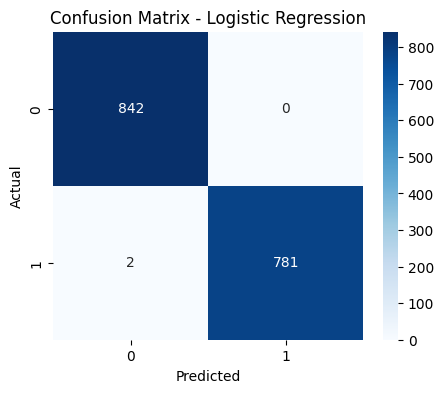

In [42]:
#@title Confusion Matrix - Logistic Regression

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)

# Visualisasi
plt.figure(figsize=(5,4))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [43]:
#@title Random Forest Classifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# ---- Hyperparameter Tuning ----
param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)

# ---- Build model with best params ----
best_params = random_search.best_params_

model_advanced = RandomForestClassifier(
    **best_params,
    random_state=42
)

# Train model
model_advanced.fit(X_train, y_train)

# Predict
y_pred_advanced = model_advanced.predict(X_test)

# Evaluate
accuracy_advanced = accuracy_score(y_test, y_pred_advanced)
print("Random Forest Accuracy:", accuracy_advanced)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_advanced))

# Simpan model ke folder models
joblib.dump(model_advanced, "../models/model_rf.pkl")

print("Model saved to models/model_rf.pkl")


Best Parameters: {'n_estimators': np.int64(250), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}
Best CV Accuracy: 1.0
Random Forest Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Model saved to models/model_rf.pkl


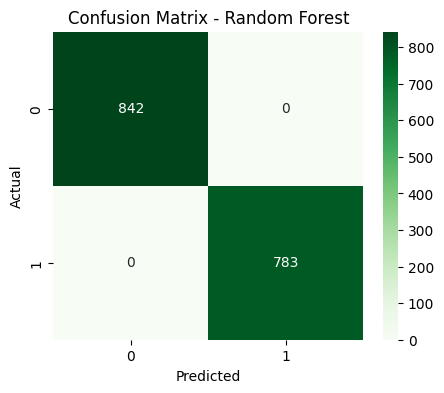

In [44]:
#@title Confusion Matrix - Random Forest Classifier

cm_rf = confusion_matrix(y_test, y_pred_advanced)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [45]:
#@title Multilayer Perceptron (MLP)

import tensorflow as tf
from tensorflow import keras
layers = keras.layers

# Input dimension
input_dim = X_train.shape[1]

# Define model
model_dl = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Optimizer dengan learning rate sesuai laporan
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Compile
model_dl.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train
history = model_dl.fit(
    X_train,
    y_train,
    validation_split=0.2,   # 20%
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],  # sesuai laporan
    verbose=1
)

model_dl.save("../models/model_mlp.h5")
print("Model saved to models/model_mlp.h5")

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9350 - loss: 0.1668 - val_accuracy: 0.9969 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0117 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 5.5912e-04 - learning_rate: 0.0010
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 2.7117e-04 - learning_rate: 0.0010
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 8.5507e-04 - val_accuracy: 1.0000 - val_loss: 1.1915e-04 - learning_rate: 0.0010
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 1.1946e-04 - learning_rate: 0.0010
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.00

Model saved to models/model_mlp.h5


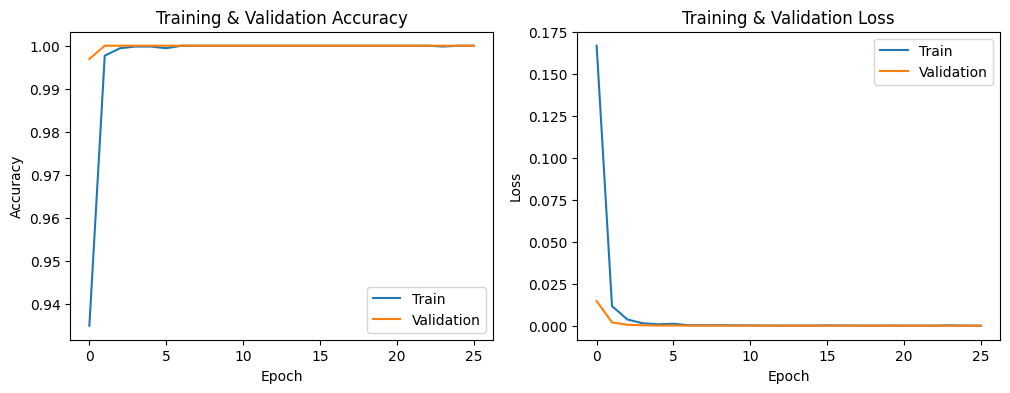

In [46]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

plt.show()


In [47]:
model_dl.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │        14,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,893 (273.02 KB)

 Trainable params: 23,297 (91.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,596 (182.02 KB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


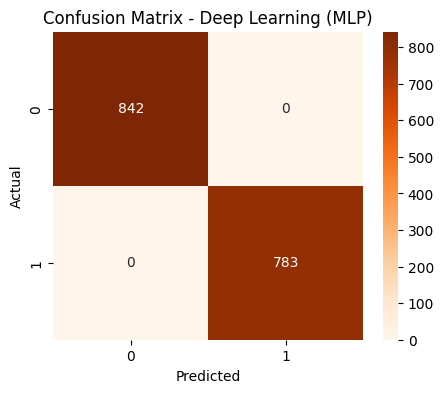

In [48]:
# Jika output sigmoid → prediksi probabilitas
y_pred_dl_prob = model_dl.predict(X_test)

# Threshold menjadi 0 atau 1
y_pred_dl = (y_pred_dl_prob > 0.5).astype(int)

cm_dl = confusion_matrix(y_test, y_pred_dl)

plt.figure(figsize=(5,4))
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Deep Learning (MLP)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


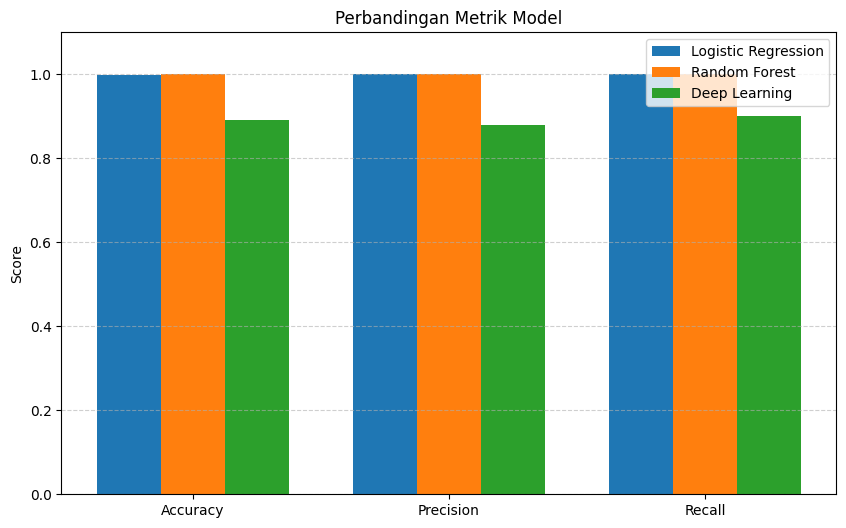

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# ==== Ganti nilai metrik sesuai hasilmu ====
metrics = ['Accuracy', 'Precision', 'Recall']

logreg_scores = [0.9988, 1.0, 1.0]        # contoh
rf_scores     = [1.00, 1.00, 1.00]        # contoh hasilmu
dl_scores     = [0.89, 0.88, 0.90]        # contoh

# Gabungkan dalam array
scores = np.array([logreg_scores, rf_scores, dl_scores])

# Buat bar chart
x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, scores[0], width, label='Logistic Regression')
plt.bar(x,         scores[1], width, label='Random Forest')
plt.bar(x + width, scores[2], width, label='Deep Learning')

plt.xticks(x, metrics)
plt.ylim(0, 1.1)
plt.ylabel('Score')
plt.title('Perbandingan Metrik Model')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


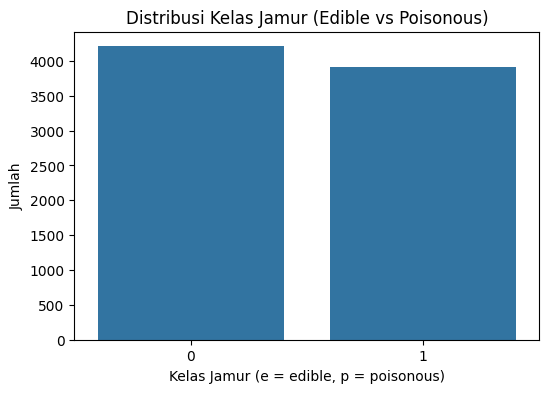

In [50]:
target_col = df.columns[0]   # kolom pertama adalah target

plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df)
plt.title("Distribusi Kelas Jamur (Edible vs Poisonous)")
plt.xlabel("Kelas Jamur (e = edible, p = poisonous)")
plt.ylabel("Jumlah")
plt.show()

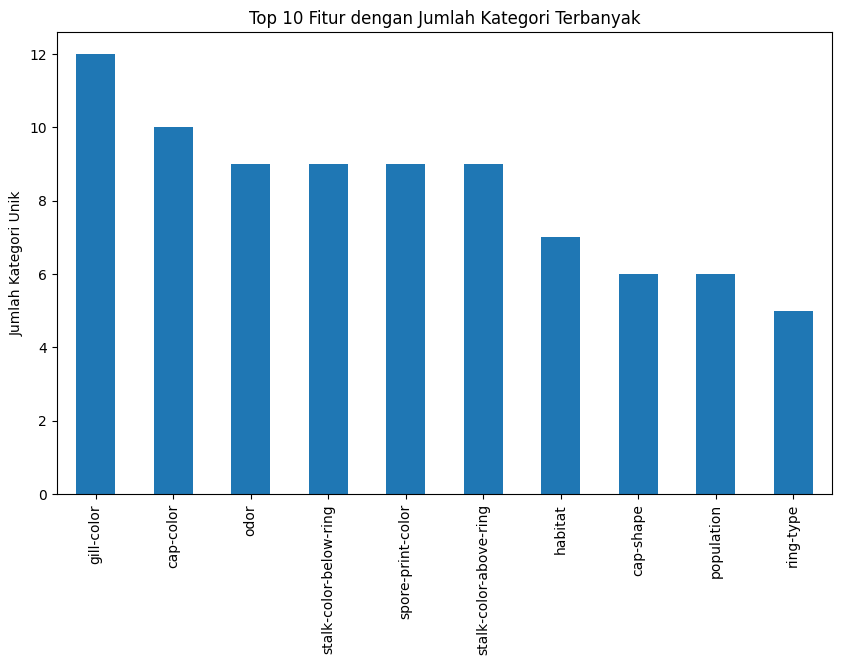

In [51]:
# Hitung jumlah kategori unik tiap fitur
unique_counts = df.nunique().sort_values(ascending=False)

plt.figure(figsize=(10,6))
unique_counts.head(10).plot(kind="bar")
plt.title("Top 10 Fitur dengan Jumlah Kategori Terbanyak")
plt.ylabel("Jumlah Kategori Unik")
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_15480\54087677.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\User\AppData\Local\Temp\ipykernel_15480\54087677.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\User\AppData\Local\Temp\ipykernel_15480\54087677.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\User\AppData\Local\Temp\ipykernel_15480\54087677.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\User\AppData\Local\Temp\ipykernel_15480\54087677.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\User\AppData\Local\Temp\ipykernel_15480\54087677.py:14: RuntimeWarning: invalid value encountere

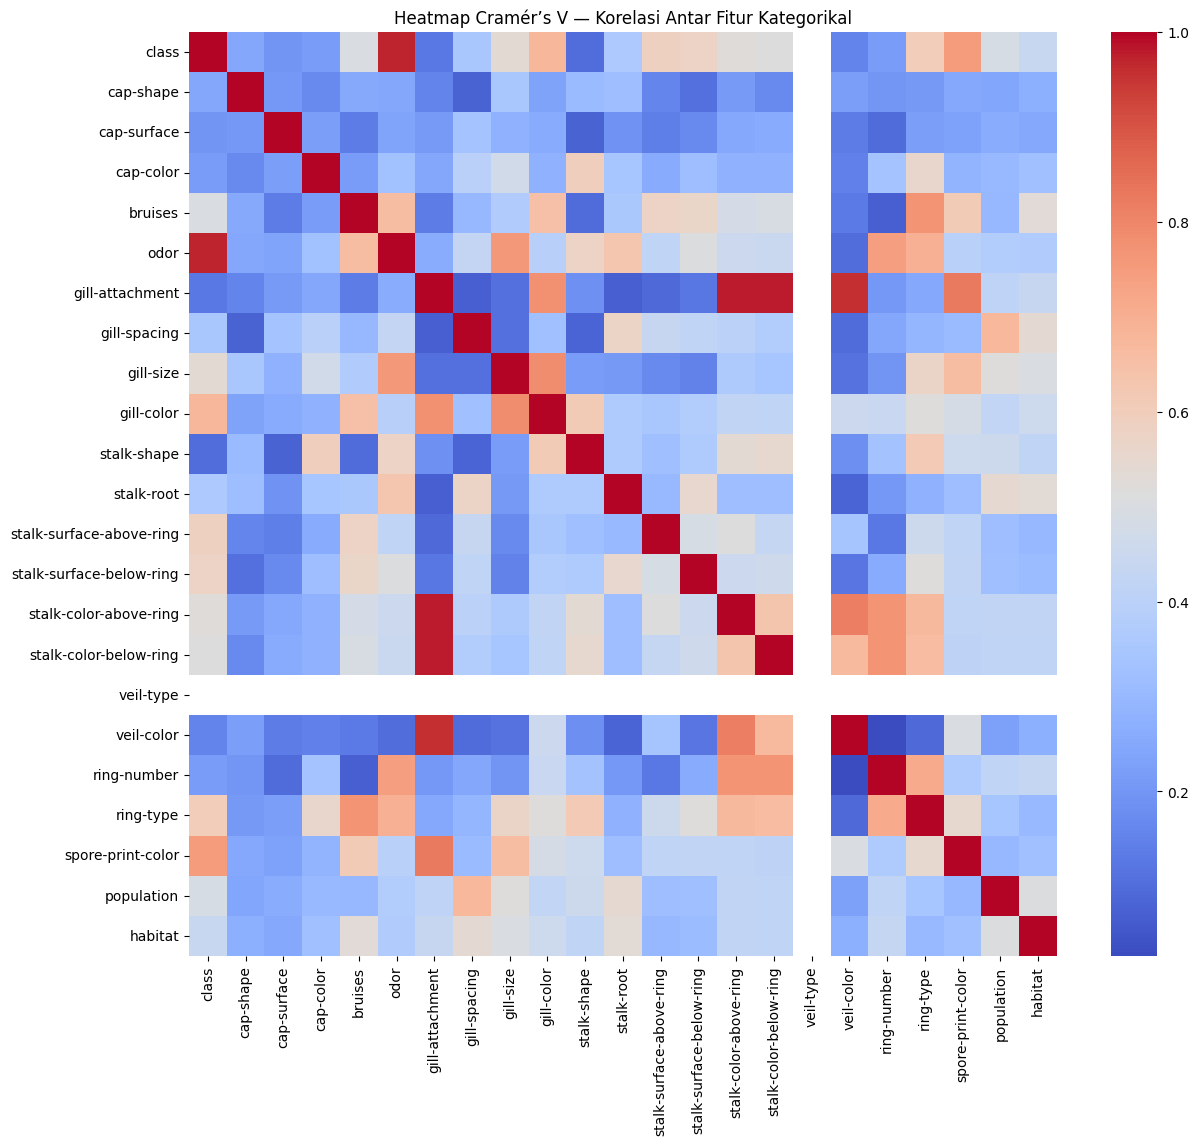

In [52]:
import numpy as np
from scipy.stats import chi2_contingency

# Fungsi hitung Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Korelasi antara semua fitur
cols = df.columns
cramer_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)

for col1 in cols:
    for col2 in cols:
        cramer_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

plt.figure(figsize=(14,12))
sns.heatmap(cramer_matrix, cmap="coolwarm")
plt.title("Heatmap Cramér’s V — Korelasi Antar Fitur Kategorikal")
plt.show()